In [1]:
import cufflinks
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from sklearn.linear_model import LinearRegression
import re
import os
import glob  # 找某个文件下的目录名
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
# import plotly.plotly as py
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# 驱虫市场潜力分析

In [2]:
# 切换目录
os.chdir("D:\LearnJupyter\电商文本挖掘\电商文本挖掘\data\驱虫剂市场")

In [3]:
filesnames1 = glob.glob("*市场近三年交易额*")  # 查找目录下符合条件的文件名
filesnames1

['灭鼠杀虫剂市场近三年交易额.xlsx',
 '电蚊香套装市场近三年交易额.xlsx',
 '盘香灭蟑香蚊香盘市场近三年交易额.xlsx',
 '蚊香加热器市场近三年交易额.xlsx',
 '蚊香液市场近三年交易额.xlsx',
 '蚊香片市场近三年交易额.xlsx',
 '防霉防蛀片市场近三年交易额.xlsx']

In [4]:
re.search(r".*(?=市场)", '灭鼠杀虫剂市场近三年交易额.xlsx').group()  # 搜索 “市场”前面的字段

'灭鼠杀虫剂'

- 定义函数，读取单个excel文件，转换成DataFrame，并重新更换列名，
将时间列变为datetime类型并将时间列变为index

In [5]:
def read_threes(filename):
    colname = re.search(r".*(?=市场)", filename).group()  # 提取文件名中，“市场”之前的文字
    df = pd.read_excel(filename)
    if df["时间"].dtypes == "int64":
        # unit 代表按照什么来  origin 代表时间源  pd.Timestamp(“1899-12-30”)
        # 将“时间”列的数据类型转变为datetime类型
        df["时间"] = pd.to_datetime(
            df["时间"], unit="D", origin=pd.Timestamp('1899-12-30'))
    df.rename(columns={df.columns[1]: colname},
              inplace=True)  # 修改第二列的列名 并将时间列变成一个index
    df.set_index("时间", inplace=True)
    return df

In [6]:
# 分别读取七个文件 并转换成dataframe存入列表中
dfs = [read_threes(filename) for filename in filesnames1]

In [7]:
df = pd.concat(dfs, axis=1).reset_index()
df.head()

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,2018-10-01,1.136548e+08,106531.29,4171283.35,315639.48,7814546.15,1032414.29,8541153.59
1,2018-09-01,1.440261e+08,105666.63,6784500.17,457366.41,10654973.47,1566651.88,8825870.43
2,2018-08-01,1.540426e+08,201467.03,10709683.41,746513.13,17835577.80,2617149.00,6320153.44
3,2018-07-01,1.480032e+08,438635.29,16589184.89,1871757.00,38877917.83,6209040.06,6302595.06
4,2018-06-01,1.359438e+08,953749.78,23526385.73,3641025.92,76499091.86,12484919.63,7047206.98


- 查看各列数据基本情况

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
灭鼠杀虫剂,36.0,7.019891e+07,4.011150e+07,15001352.47,3.627072e+07,6.128952e+07,1.019937e+08,1.540426e+08
电蚊香套装,36.0,6.052237e+05,7.905252e+05,33232.95,1.064713e+05,2.263255e+05,9.182515e+05,3.606142e+06
盘香灭蟑香蚊香盘,36.0,6.988421e+06,7.340759e+06,449199.41,1.227319e+06,4.280573e+06,1.011202e+07,2.811858e+07
蚊香加热器,36.0,9.204170e+05,1.226545e+06,34076.91,8.683504e+04,3.164230e+05,1.407050e+06,5.032467e+06
蚊香液,36.0,2.367506e+07,2.973022e+07,482889.01,2.628064e+06,8.395108e+06,3.980283e+07,1.050396e+08
蚊香片,36.0,3.559793e+06,4.508172e+06,109108.05,4.661788e+05,1.443026e+06,6.210521e+06,1.596195e+07
防霉防蛀片,36.0,5.012875e+06,2.085349e+06,1274810.96,3.451924e+06,5.332902e+06,6.410655e+06,8.825870e+06


- 判断是否有空值

In [9]:
df.isnull().any()
# df.isna().mean(axis=1)

时间          False
灭鼠杀虫剂       False
电蚊香套装       False
盘香灭蟑香蚊香盘    False
蚊香加热器       False
蚊香液         False
蚊香片         False
防霉防蛀片       False
dtype: bool

- 抽取所有的月份作为单独一列

In [10]:
month = df["时间"].dt.month

- 循环预测2018年11月、12月各子类目的销售额

In [11]:
for i in [11, 12]:
    dm = df[month == i]  # 从df中抽取对应月份的记录
    x_train = np.array(dm["时间"].dt.year).reshape(-1, 1)  # 取出年份
    y_hat = [pd.datetime(2018, i, 1)]
    for j in range(1, len(dm.columns)):  # 遍历对应月份的每个种类
        y_train = dm.iloc[:, j]  # 获取对应种类的交易金额作为训练样本集目标值
        reg = LinearRegression()
        reg.fit(x_train, y_train)
        y_predict = reg.predict(
            np.array([2018]).reshape(-1, 1))  # 得到我们想要得到的预测值
        y_hat.append(y_predict)
    newrow = pd.DataFrame(dict(zip(df.columns, y_hat)))  # 将结果变成DataFrame
    df = newrow.append(df)  # 将预测的DataFrame追加到df中

<ipython-input-11-165947397eaa>:4: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

<ipython-input-11-165947397eaa>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-11-165947397eaa>:4: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [12]:
df.reset_index(drop=True, inplace=True)

In [13]:
df = df[df["时间"].dt.year != 2015]  # 拿到除2015年之外的所有年份

   - 添加新列用来存储每天的交易金额总和

In [14]:
df["colsum"] = df.sum(axis=1)

- 插入一个年分列“year”

In [15]:
df.insert(1, "year", df["时间"].dt.year)
df.head()

,时间,year,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2018-12-01,2018,5.256763e+07,50204.53,9.285543e+05,86849.166667,3.081492e+06,4.268126e+05,3958717.58,6.110026e+07
1,2018-11-01,2018,7.175250e+07,38692.61,1.801319e+06,193874.386667,5.543204e+06,7.766270e+05,6678677.55,8.678489e+07
2,2018-10-01,2018,1.136548e+08,106531.29,4.171283e+06,315639.480000,7.814546e+06,1.032414e+06,8541153.59,1.356363e+08
3,2018-09-01,2018,1.440261e+08,105666.63,6.784500e+06,457366.410000,1.065497e+07,1.566652e+06,8825870.43,1.724211e+08
4,2018-08-01,2018,1.540426e+08,201467.03,1.070968e+07,746513.130000,1.783558e+07,2.617149e+06,6320153.44,1.924731e+08


- 根据年分组并求和

In [16]:
by_year = df.groupby("year").sum().reset_index()
by_year.head()

,year,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2016,6.080471e+08,7666572.12,4.785285e+07,5.905205e+06,1.704905e+08,27980839.47,50023001.94,9.179661e+08
1,2017,8.477740e+08,9377531.68,8.635539e+07,1.055284e+07,3.300656e+08,49068587.96,62678822.18,1.395873e+09
2,2018,1.137893e+09,4537682.09,1.180885e+08,1.683672e+07,3.582077e+08,51845921.56,72701365.23,1.760111e+09


# 按照年份查看驱虫市场总体变化趋势

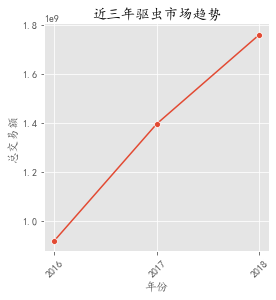

In [17]:
sns.set_style()
sns.relplot(x="year", y="colsum", data=by_year,
            kind="line", marker="o", height=4)
plt.xticks(by_year.year, rotation=45)  # 设置x轴的刻度值，旋转刻度值
plt.title("近三年驱虫市场趋势")
plt.xlabel("年份")
plt.ylabel("总交易额")
plt.show()

## 驱虫市场潜力分析-各市场变化趋势


###  查看各类目市场三年内销售额总和的变化趋势

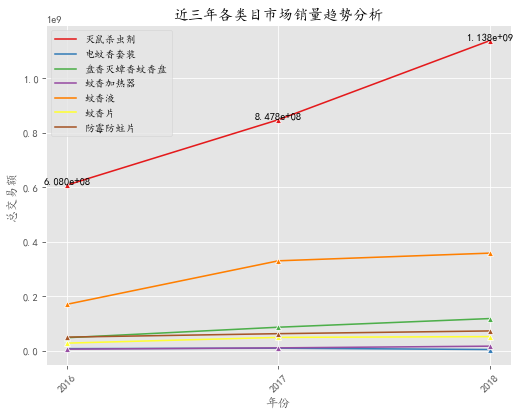

In [18]:
# 没有说明X轴与Y轴的数据，则元数据的索引值作为X轴，每一列的值作为Y轴的数据
# dashes = False 默认只能显示六种样式，设置False则不区分
sns.set_style()
plt.subplots(figsize=(8, 6), dpi=75)
sns.lineplot(data=by_year.set_index(
    "year").iloc[:, :-1], marker="^", dashes=False, palette="Set1")
for x, y in zip(by_year["year"], by_year["灭鼠杀虫剂"]):
    # 在图中x，y中加入文本    ha垂直对齐   va 水平对齐
    plt.text(x=x, y=y, s="%.3e" % y, ha="center",
             va="bottom")  # 保留三位小数 并以e的次方来表示数据
plt.title("近三年各类目市场销量趋势分析")
plt.xticks(by_year.year, rotation=45)
plt.xlabel("年份")
plt.ylabel("总交易额")
plt.show()

### 驱虫市场的潜力分析 - 各市场占比
- 查看各类目市场三年内销售额总和的占比

In [19]:
# div  除法  axis = 0 从下往上   axis = 1 从左到右
# 用by_year.iloc[:,1:-1]的每一行 去 除 by_year["colsum"]
by_year_per = by_year.iloc[:, 1:-
                           1].div(by_year["colsum"], axis=0)  # 每个种类在当年的销售额占比
by_year_per.index = by_year.year  # 将by_year_per 的索引设为 by_year 年份

- 直接使用DataFrame画图

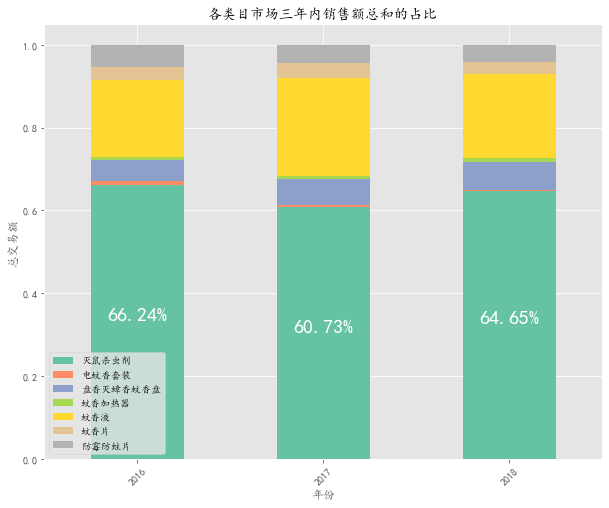

In [20]:
# stacked = True 是否设为堆积条图
sns.set_style()
by_year_per.plot(figsize=(10, 8), kind="bar",
                 stacked=True, title="各类目市场三年内销售额总和的占比", colormap="Set2")
plt.xlabel("年份")
plt.xticks(rotation=45)
plt.ylabel("总交易额")
# 对于条形图来说 位置x从0开始
for x, y in zip(range(len(by_year_per)), by_year_per["灭鼠杀虫剂"]):
    plt.text(x, y/2, str(round(y*100, 2))+"%",
             ha="center", va="bottom", size=20, color="w")
plt.show()

### 驱虫市场的潜力分析-各市场年增幅
-  进一步分析各类目市场16-17年17-18年增幅

In [21]:
by_year.iloc[:, 1:-1].diff().iloc[1:, :]  # diff 和 by_year - by_year.shift()相等

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
1,2.397269e+08,1710959.56,3.850254e+07,4.647636e+06,1.595750e+08,21087748.49,12655820.24
2,2.901194e+08,-4839849.59,3.173312e+07,6.283882e+06,2.814215e+07,2777333.60,10022543.05


In [22]:
by_year_up = by_year.iloc[:, 1:-1]  # 增量
by_year_diff = (by_year_up.diff().iloc[1:, :].reset_index(
    drop=True))/by_year_up.iloc[:2, :]
# by_year_up.diff().dropna().reset_index(drop=True)/by_year_up[:2].reset_index(drop=True) #这两种方式都行
by_year_diff.index = ["16-17", "17-18"]
by_year_diff

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
16-17,0.394257,0.223171,0.804603,0.787041,0.935976,0.753650,0.253000
17-18,0.342213,-0.516111,0.367471,0.595468,0.085262,0.056601,0.159903


Text(0.5, 1.0, '各市场年增幅')

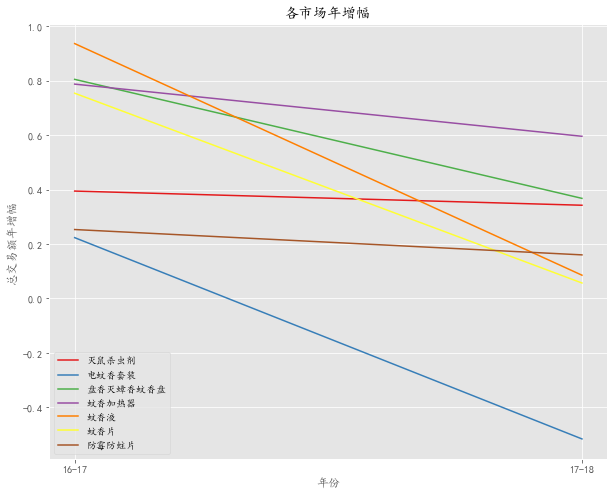

In [23]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=by_year_diff, dashes=False, palette="Set1")
plt.legend(loc=3)
plt.xlabel("年份")
plt.ylabel("总交易额年增幅")
plt.title("各市场年增幅")

### 驱虫市场的潜力分析-垄断
- HHI指数：能区别公司市场占有率 与市场垄断程度呈正相关
- 指标是行业集中度
- 指标范围：
    - [1/N,‘高度竞争行业’,0.01],
    -  (0.01,‘不集中的行业’,0.15],
    - (0.15,‘中等集中’,0.25],
    - (0.25,‘高度集中’,1]

In [24]:
df_top100 = pd.read_excel("./top100品牌数据.xlsx")
df_top100.head()

,品牌,行业排名,交易指数,交易增长幅度,支付转化指数,操作
0,PREMISE/拜灭士,1,530344,-0.3235,1521,趋势分析
1,科凌虫控,2,474937,-0.1910,1581,趋势分析
2,ARS/安速,3,402372,-0.2682,1448,趋势分析
3,思乐智,4,360780,0.2056,841,趋势分析
4,希诺,5,346656,-0.1085,1865,趋势分析


-  添加“交易指数占比“列，代表市场占有率（市场份额）

In [25]:
df_top100["交易指数占比"] = df_top100["交易指数"]/df_top100["交易指数"].sum()
df_top100.head()

,品牌,行业排名,交易指数,交易增长幅度,支付转化指数,操作,交易指数占比
0,PREMISE/拜灭士,1,530344,-0.3235,1521,趋势分析,0.035998
1,科凌虫控,2,474937,-0.1910,1581,趋势分析,0.032237
2,ARS/安速,3,402372,-0.2682,1448,趋势分析,0.027311
3,思乐智,4,360780,0.2056,841,趋势分析,0.024488
4,希诺,5,346656,-0.1085,1865,趋势分析,0.023530


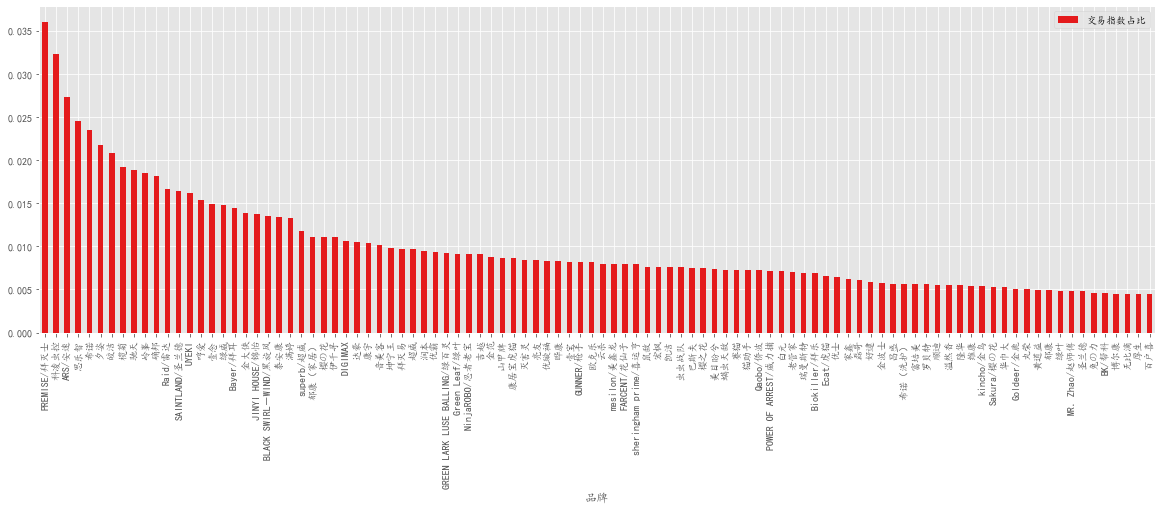

In [26]:
df_top100.plot(x="品牌", y="交易指数占比", kind="bar",
               figsize=(20, 6), colormap="Set1")
plt.show()

In [27]:
HHI = sum(df_top100["交易指数占比"]**2)
HHI  # 所有市场份额的 平方和

0.013546334007208914

# 灭鼠杀虫剂市场机会点-产品类别
 - 读取五个文件进行合并
 

In [28]:
os.chdir(r"../灭鼠杀虫剂细分市场/")  # 切换目录
filenames2 = glob.glob("*.xlsx")

In [29]:
dfs2 = [pd.read_excel(filename) for filename in filenames2]

In [30]:
dfs2 = pd.concat(dfs2, sort=False)  # 合并列表中的五个DataFrame

In [31]:
dfs2.shape

(6556, 229)

In [32]:
col_index = dfs2.isnull().mean() > 0.98  # 查看每列的缺失值是否超过98%
df21 = dfs2.loc[:, ~col_index]  # 过滤掉缺失值占比超过98%的特征
df21.shape

(6556, 38)

In [33]:
# nunique() 代表去重后的元素个数
col_index2 = np.array([df21[column].nunique() == 1 for column in df21.columns])

In [34]:
df22 = df21.loc[:, ~col_index2]
df22.shape

(6556, 37)

- 可以看出删掉了一个

In [35]:
col_index3 = df22.columns.get_loc("药品登记号")  # 获取 “药品登记号”的索引
df23 = df22.iloc[:, :col_index3]
df23.shape

(6556, 24)

In [36]:
useless = ["时间", "链接", "主图链接", "主图视频链接",
           "页码", "排名", "宝贝标题", "运费", "下架时间", "旺旺"]
df23.drop(useless, axis=1, inplace=True)
df23.shape

(6556, 14)

In [37]:
df23.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 1742
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   类别      6556 non-null   object 
 1   宝贝ID    6556 non-null   int64  
 2   销量（人数）  6556 non-null   int64  
 3   售价      6556 non-null   float64
 4   预估销售额   6520 non-null   float64
 5   评价人数    6406 non-null   float64
 6   收藏人数    6556 non-null   int64  
 7   地域      3888 non-null   object 
 8   店铺类型    6556 non-null   object 
 9   品牌      5931 non-null   object 
 10  型号      3781 non-null   object 
 11  净含量     3792 non-null   object 
 12  适用对象    4721 non-null   object 
 13  物理形态    4679 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 768.3+ KB


In [38]:
df24 = df23.astype({"宝贝ID": object})
df24.reset_index(drop=True, inplace=True)
df24.head()

,类别,宝贝ID,销量（人数）,售价,预估销售额,评价人数,收藏人数,地域,店铺类型,品牌,型号,净含量,适用对象,物理形态
0,杀虫,578459866289,99,29.9,2960.1,26.0,202,NaN,天猫,拜耳,特姆得,NaN,蟑螂,液体
1,杀虫,548196868239,99,0.6,59.4,1330.0,242,浙江 金华,淘宝,佰凌,180325,NaN,NaN,NaN
2,杀虫,580839295562,99,98.0,9702.0,44.0,27,广东 深圳,淘宝,NaN,NaN,NaN,NaN,NaN
3,杀虫,580264662322,99,6.9,683.1,24.0,26,河南 商丘,淘宝,SHURONGCROP/树荣作物,NaN,30g,NaN,NaN
4,杀虫,44484517973,99,18.8,1861.2,121.0,133,河北 秦皇岛,天猫,Raid/雷达,雷达杀虫气雾剂清香,600ml,蟑螂,喷雾


In [39]:
df24.dtypes

类别         object
宝贝ID       object
销量（人数）      int64
售价        float64
预估销售额     float64
评价人数      float64
收藏人数        int64
地域         object
店铺类型       object
品牌         object
型号         object
净含量        object
适用对象       object
物理形态       object
dtype: object

In [40]:
df24.describe().T

,count,mean,std,min,25%,50%,75%,max
销量（人数）,6556.0,324.518609,3207.470186,0.00,14.0000,26.0,70.00,143037.0
售价,6556.0,39.559527,49.678113,0.01,13.9000,25.8,48.00,618.0
预估销售额,6520.0,10326.764212,78511.931038,0.01,230.7375,674.1,2288.00,2672898.0
评价人数,6406.0,1942.746800,13493.925308,0.00,36.0000,160.0,602.75,502295.0
收藏人数,6556.0,1345.778981,6947.250438,0.00,33.0000,133.0,496.50,234645.0


In [41]:
df24.groupby("类别")["预估销售额"].sum()

类别
杀虫     8207628.10
灭鼠    25686011.99
虱      4512886.01
螨     10886752.88
蟑螂    18037223.68
Name: 预估销售额, dtype: float64

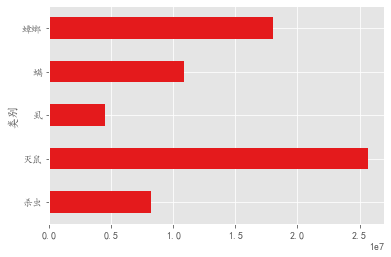

In [42]:
by_class = df24["预估销售额"].groupby(df24["类别"]).sum()  # 获取通过类别分组的销售额总和
by_class.plot.barh(colormap="Set1")  # 使用Series对象进行绘制
plt.show()

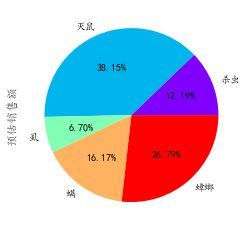

In [43]:
by_class.plot.pie(autopct="%.2f%%", colormap="rainbow")  # 使用Series对象绘制饼图
plt.show()

# 灭鼠类别机会点--灭鼠类别分析

In [44]:
# df24[df24["类别"]=='灭鼠'] # 两种方式均可
df25 = df24.query("类别=='灭鼠'")  # 选择灭鼠数据

- 依据“售价”进行价格划分，得到价格区间
- 每个价格区间计算：预估销售额（总和），销售额占比，宝贝数占比，单宝贝平均销售额，相对竞争度

In [45]:
bins = [0, 50, 100, 150, 200, 250, 300, 1000]  # 售价划分刻度
labels = ["0_50", "50_100", "100_150",
          "150_200", "200_250", "250_300", "300以上"]
df25 = df25.copy()  # 防止他报警告
df25["价格区间"] = pd.cut(df25["售价"], bins=bins,
                      labels=labels, include_lowest=True)
# include_lowest=True 代表包不包括下一个区间   设置边界标签的归属
df25["价格区间"].value_counts()

0_50       1138
50_100      242
100_150      62
150_200      35
300以上        28
250_300       9
200_250       9
Name: 价格区间, dtype: int64

In [46]:
df25.head()

,类别,宝贝ID,销量（人数）,售价,预估销售额,评价人数,收藏人数,地域,店铺类型,品牌,型号,净含量,适用对象,物理形态,价格区间
2000,灭鼠,566054780243,9976,26.8,267356.8,11901.0,11596,广东 韶关,天猫,优璇福,MT007,NaN,老鼠,胶水,0_50
2001,灭鼠,566054780243,9976,26.8,267356.8,NaN,11596,广东 深圳,天猫,优璇福,MT007,NaN,老鼠,胶水,0_50
2002,灭鼠,572115448996,9945,9.9,98455.5,26442.0,3569,NaN,淘宝,创驰,21/32,NaN,老鼠,固体,0_50
2003,灭鼠,39868408322,99,29.9,2960.1,20.0,352,河南 南阳,天猫,云杀,粘鼠板,NaN,老鼠,固体,0_50
2004,灭鼠,520282897220,99,39.9,3950.1,559.0,1250,NaN,淘宝,得硕,NaN,g,老鼠,固体,0_50


- 编写函数，根据指定字段分组，组装新的DataFrame

In [47]:
def by_function(df, by, sort="单宝贝平均销售额"):
    # 特别注意。多加个中括号保证取出来的仍然是DataFrame
    by_type = df.groupby(by).sum().loc[:, ["预估销售额"]]
    by_type["销售额占比"] = by_type["预估销售额"]/by_type["预估销售额"].sum()
    # datafarme中nunique代表对分组后的 该列的不重复值
    by_type["宝贝数"] = df.groupby(by).nunique().loc[:, "宝贝ID"]
    by_type["宝贝数占比"] = by_type["宝贝数"]/by_type["宝贝数"].sum()
    by_type["单宝贝平均销售额"] = by_type["预估销售额"] / by_type["宝贝数"]
    by_type["相对竞争度"] = 1 - (by_type["单宝贝平均销售额"] -
                            by_type["单宝贝平均销售额"].min()) / (by_type["单宝贝平均销售额"].max() -
                                                          by_type["单宝贝平均销售额"].min())
    if sort:
        by_type.sort_values(sort, ascending=False, inplace=True)
    return by_type

In [48]:
by_price = by_function(df25, "价格区间")

- 编写绘图函数绘制“相对竞争度”和“销售额占比”

In [49]:
def draw_plot(df, figsize=(10, 4)):
    ax = df.plot(y="相对竞争度", ls="-.", lw=3, marker="o",
                 figsize=figsize, colormap="rainbow")  # 返回的是一个坐标
    df.plot(y="销售额占比", colormap="Set1", kind="bar",
            alpha=0.6, ax=ax)  # ax=ax 将两个图联系起来
    plt.show()

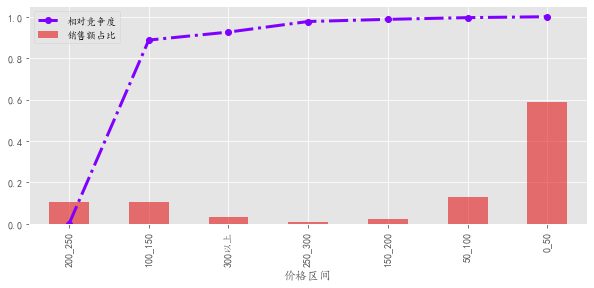

In [50]:
draw_plot(by_price)

## 灭鼠类别 0_50细分价格市场

In [51]:
df50 = df25[df25["价格区间"] == '0_50']  # 选择灭鼠种类0_50价格区间的数据

In [52]:
# df50["价格区间"].nunique() # 查看该列有多少不重复的值
df50["价格区间"].value_counts()

0_50       1138
300以上         0
250_300       0
200_250       0
150_200       0
100_150       0
50_100        0
Name: 价格区间, dtype: int64

In [53]:
bins2 = [0, 10, 20, 30, 40, 50]  # 售价划分刻度
labels2 = ["0_10", "10_20", "20_30", "30_40", "40_50"]
# 划分细分价格区间，并将其添加到新列中
df50 = df50.copy()
df50["价格子区间"] = pd.cut(df50["售价"], bins=bins2,
                       labels=labels2, include_lowest=True)

In [54]:
by_son_price = by_function(df50, "价格子区间")

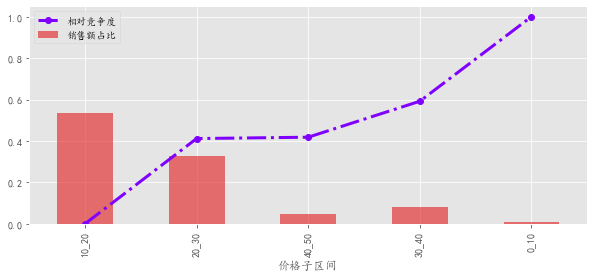

In [55]:
draw_plot(by_son_price)

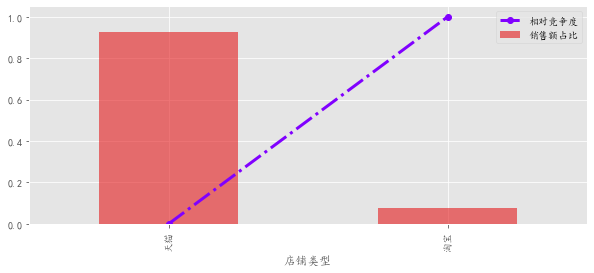

In [56]:
by_market = by_function(df50, "店铺类型")
draw_plot(by_market)

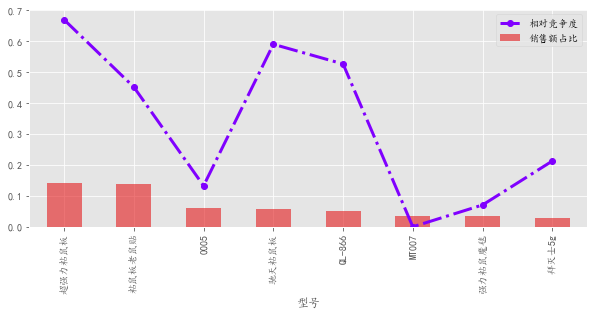

In [57]:
by_xh = by_function(df50, "型号", sort="预估销售额")  # 先用型号进行分组
df_xh = by_xh[by_xh["预估销售额"] > by_xh["预估销售额"].quantile(0.98)]  # 选取预估销售额前5%的商品
draw_plot(df_xh)

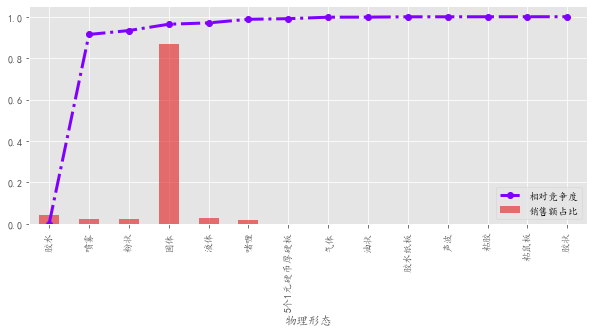

In [58]:
df_wl = by_function(df50, "物理形态")
draw_plot(df_wl)

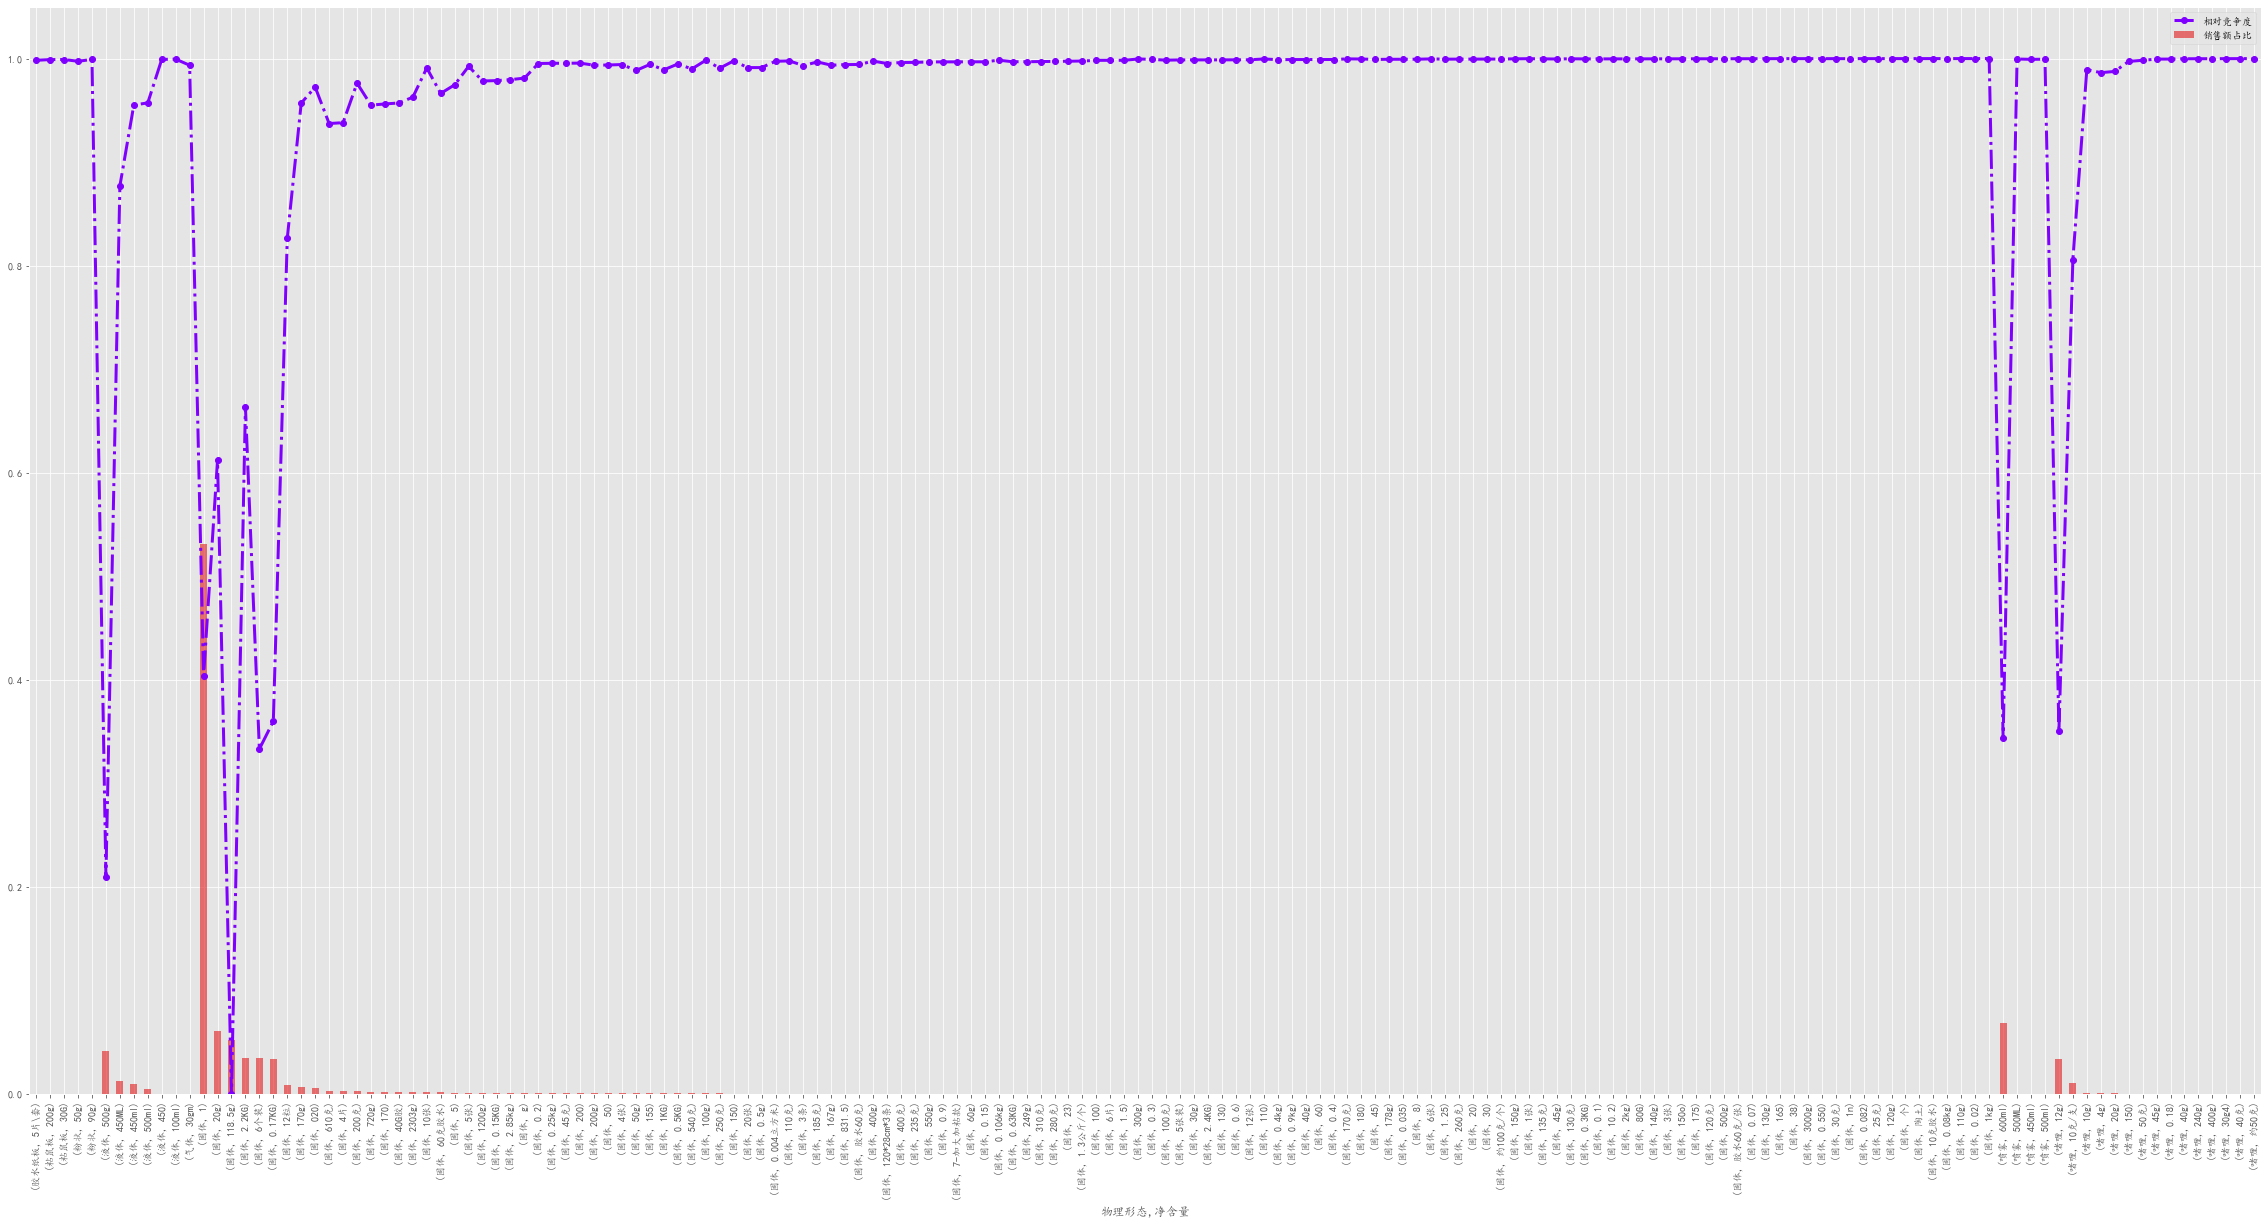

In [59]:
df_wl = by_function(df50, ["物理形态", "净含量"], sort=["物理形态", "预估销售额"])
draw_plot(df_wl, figsize=(40, 20))

## 竞争分析--销售数据分析

In [60]:
os.chdir(r"D:\LearnJupyter\电商文本挖掘\电商文本挖掘\data\竞争数据\商品销售数据")  # 切换目录
filenames3 = glob.glob("*.xlsx")
filenames3

['安速家居近30天销售数据.xlsx', '拜耳近30天销售数据.xlsx', '科凌虫控旗舰店近30天销售数据.xlsx']

In [61]:
def read_sales(filename):
    df = pd.read_excel(filename)
    useless = ["序号", "店铺名称", "商品名称", "主图链接", "商品链接"]
    df.drop(columns=useless, inplace=True)
    return df

In [62]:
dfs3 = [read_sales(file) for file in filenames3]

In [63]:
df_bai = dfs3[1]  # 拜耳的商品交易数据
df_an = dfs3[0]  # 安速的商品交易数据
df_ke = dfs3[2]  # 科凌虫控商品交易数据

In [64]:
df_bai_category = df_bai.groupby("类目").sum()  # 通过类目分组求和
df_an_category = df_an.groupby("类目").sum()  # 通过类目分组求和
df_ke_category = df_ke.groupby("类目").sum()  # 通过类目分组求和

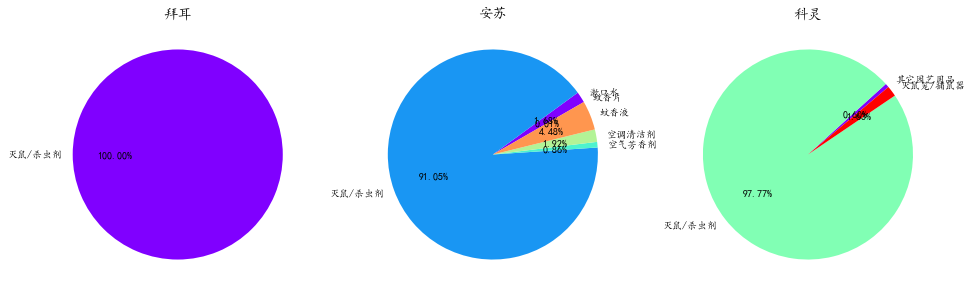

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))  # 规划绘图，返回图象对象和绘图区域数组
ax = axes[0]  # 选择第一个绘图区域
df_bai_category["销售额"].plot.pie(
    autopct="%.2f%%", ax=ax, colormap="rainbow", title="拜耳")
ax.set_ylabel("")  # 取消y的标签
df_an_category["30天销售额"].plot.pie(
    autopct="%.2f%%", ax=axes[1], startangle=30, colormap="rainbow", title="安苏")  # startangle 偏移度
axes[1].set_ylabel("")  # 取消y的标签
df_ke_category["30天销售额"].plot.pie(
    autopct="%.2f%%", ax=axes[2], startangle=40, colormap="rainbow", title="科灵")
axes[2].set_ylabel("")  # 取消y的标签
plt.show()

In [66]:
df_bai_use = df_bai.groupby("使用对象").sum()
df_an_use = df_an.groupby("适用对象").sum()
df_ke_use = df_ke.groupby("适用对象").sum()

In [67]:
df_bai_use

,商品ID,商品原价,商品售价,30天销售量,总销量,销售额
使用对象,,,,,,
上门服务,578090143145,199.0,99.0,74,308,7326.0
杀虫剂,1074833731154,208.0,79.8,2593,187382,103460.7
白蚁,530229854741,199.0,89.9,838,70516,75336.2
蚂蚁,1106313745903,448.0,173.9,4989,286942,305820.0
蟑螂,4996641317123,1569.0,752.4,50691,3175263,2181372.3


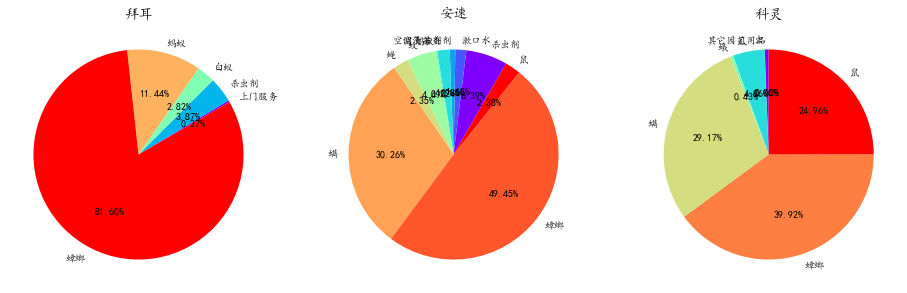

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
ax = axes[0]
df_bai_use["销售额"].plot.pie(ax=ax, autopct="%.2f%%",
                           colormap="rainbow", startangle=30, title="拜耳")
ax.set_ylabel("")
ax = axes[1]
df_an_use["30天销售额"].plot.pie(
    ax=ax, autopct="%.2f%%", colormap="rainbow", startangle=60, title="安速")
ax.set_ylabel("")
ax = axes[2]
df_ke_use["30天销售额"].plot.pie(
    ax=ax, autopct="%.2f%%", colormap="rainbow", startangle=90, title="科灵")
ax.set_ylabel("")
plt.show()

## 竞争分析-产品结构

- 拜耳产品结构分析

In [73]:
os.chdir(r"D:\LearnJupyter\电商文本挖掘\电商文本挖掘\data\竞争数据\商品交易数据")  # 切换目录
filenames4 = glob.glob("*.xlsx")
filenames4

['安速全店商品交易数据.xlsx', '拜耳全店商品交易数据.xlsx', '科凌虫控全店商品交易数据.xlsx']

In [78]:
df_bai_jy = pd.read_excel(filenames4[1])  # 读取拜耳的交易数据

In [94]:
def product_func(df):  # 按照“商品”分组的函数 , 组装成一个新的DataFrame并返回
    df = df.copy()
    df_pro = df.groupby("商品").mean().loc[:, ["交易增长幅度"]]  # 商品分组，求均值获取交易增长幅度列
    df_pro["交易金额"] = df.groupby("商品").sum().loc[:, "交易金额"]
    df_pro["交易金额占比"] = df_pro["交易金额"] / df_pro["交易金额"].sum()
    df_pro["商品个数"] = df.groupby("商品")["交易金额"].count()
    df_pro.reset_index()
    return df_pro

- 对拜耳市场结构的数据整理

In [100]:
df_bai_product = product_func(df_bai_jy).reset_index()
df_bai_product.describe().T

,count,mean,std,min,25%,50%,75%,max
交易增长幅度,44.0,2.553993e+01,1.550838e+02,-0.292100,-0.061040,0.109000,1.28741,1.030000e+03
交易金额,44.0,1.839560e+06,6.321050e+06,22553.620000,68285.080000,206187.890000,767329.12500,4.010385e+07
交易金额占比,44.0,2.272727e-02,7.809490e-02,0.000279,0.000844,0.002547,0.00948,4.954725e-01
商品个数,44.0,3.227273e+00,1.668639e+00,1.000000,1.750000,3.000000,5.00000,5.000000e+00


## 盖帽法绘图
- 盖帽法：让数值在一个合理的区间内，方便绘图
- np.quantile() 分位数
- mask() 掩盖 也就是替换
    - 将0.9分位数以上的数据都替换成0.9分位数

In [105]:
def block(ser):
    qu = ser.quantile(0.9)  # 获取0.9分位数
    result = ser.mask(ser > qu, qu)  # 将大于0.9分位数的数据 替换成0.9分位数
    return result

In [106]:
def block_product(df):
    df_copy = df.copy()
    df_copy["交易增长幅度"] = block(df_copy["交易增长幅度"])
    df_copy["交易金额占比"] = block(df_copy["交易金额占比"])  # 盖帽法处理
    return df_copy

In [118]:
df_bai_block = block_product(df_bai_product)  # 获得盖帽后的数据
df_bai_block.head()

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
0,17年德国拜耳进口蚂蚁药拜灭易灭蚁饵剂粉除杀蚂蚁杀虫剂全窝端,-0.247600,42340.55,0.000523,1
1,德国原装进口拜耳蟑螂药全窝端拜灭士5g+12g杀蟑胶饵剂粉屋捕捉器,-0.120333,197377.17,0.002439,3
2,德国拜耳 除敌跳蚤杀虫剂家用灭蟑螂药虱子杀潮虫臭虫除虫剂喷雾,-0.221080,1394780.59,0.017232,5
3,德国拜耳丁香医生限量款拜灭士加量家用蟑螂全窝端蟑螂药3支装,1.279300,26742.75,0.000330,1
4,德国拜耳上门除灭鼠灭白蚁蟑螂蚊子跳蚤苍蝇上海地区灭虫按件拍下,2.439300,28969.28,0.000358,1


## 绘制波士顿矩阵

### 绘制波士顿矩阵的函数

In [167]:
def plotBCG(df, mean=True, q1=0.5, q2=0.5):
    plt.subplots(figsize=(10, 8))
    ax = sns.scatterplot("交易金额占比", "交易增长幅度", hue="商品个数",
                         size="商品个数", sizes=(50, 500), data=df, palette="cool", legend="full")
    for i in range(len(df)):
        ax.text(x=df["交易金额占比"][i], y=df["交易增长幅度"][i], s=i)

    if mean:
        plt.axvline(x=df["交易金额占比"].mean())  # 用交易金额占比的平均值画垂线
        plt.axhline(y=df["交易增长幅度"].mean())  # 交易增长幅度的平均值做水平线
    else:
        plt.axvline(x=df["交易金额占比"].quantile(q1),
                    color="k", ls="--")  # 用交易金额占比的平均值画垂线
        plt.axhline(y=df["交易增长幅度"].quantile(q2),
                    color="k", ls="--")  # 交易增长幅度的平均值做水平线
    plt.show()

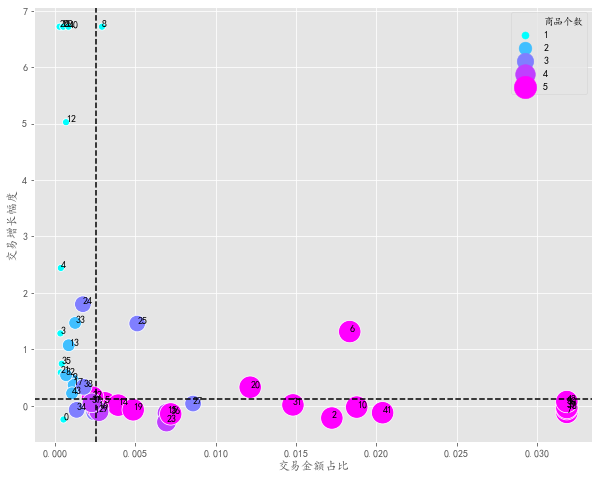

In [168]:
plotBCG(df_bai_block, mean=False)

- 交易金额占比大，交易增长幅度大 --- 明星产品
- 交易金额占比小，交易增长幅度大 --- 问题产品
- 交易金额占比大，交易增长幅度小 --- 奶牛产品
- 交易金额占比小，交易增长幅度小 --- 痩狗产品


### 区分产品结构函数

In [184]:
def extractBCG(df, q1=0.5, q2=0.5, sort="交易金额占比"):
    star = df.loc[(df["交易金额占比"] >= df["交易金额占比"].quantile(q1))
                  & (df["交易增长幅度"] >= df["交易增长幅度"].quantile(q2)), :]
    star = star.sort_values(sort, ascending=False)

    cow = df.loc[(df["交易金额占比"] >= df["交易金额占比"].quantile(q1))
                 & (df["交易增长幅度"] < df["交易增长幅度"].quantile(q2)), :]
    cow = cow.sort_values(sort, ascending=False)

    question = df.loc[(df["交易金额占比"] < df["交易金额占比"].quantile(q1))
                      & (df["交易增长幅度"] >= df["交易增长幅度"].quantile(q2)), :]
    question = question.sort_values(sort, ascending=False)

    return star, cow, question

In [185]:
star, cow, question = extractBCG(df_bai_product)
star1, cow1, question1 = extractBCG(df_bai_product, sort="交易增长幅度")

In [188]:
display(star,cow,question1)

,商品,交易增长幅度,交易金额,交易金额占比,商品个数
6,德国拜耳拜灭士5g+除敌5ml*4支进口蟑螂药家用全窝端杀蟑螂套装,1.311740,1484952.41,0.018346,5
20,德国拜耳除敌杀虫剂灭蟑螂药跳蚤苍蝇臭虫除螨虱子喷雾5ml*8,0.325580,983199.69,0.012147,5
25,拜耳拜灭士 蟑螂药家用全窝端 强力灭除厨房蟑螂屋克星杀德国进口,1.454067,413902.42,0.005114,3
8,德国拜耳拜灭士蟑螂药一窝端进口全窝端家用灭除杀蟑胶饵5g包邮,29.260600,236386.32,0.002920,1


,商品,交易增长幅度,交易金额,交易金额占比,商品个数
7,德国拜耳拜灭士蟑螂药一窝端杀蟑胶饵灭蟑螂屋无毒克星家用全窝端,-0.121360,40103850.97,0.495473,5
39,进口蟑螂药一窝端德国拜耳拜灭士强力杀蟑胶饵蟑螂屋克星家用全窝,-0.034680,13617307.87,0.168238,5
18,德国拜耳进口蚂蚁药拜灭易灭蚁饵剂除杀蚂蚁杀虫剂家用室内全窝端,-0.056240,6130488.42,0.075741,5
42,进口蟑螂药德国拜耳拜灭士灭杀蟑胶饵剂粉屋克星全窝端12g家用,0.070960,3589799.54,0.044351,5
30,蟑螂药一窝端德国拜耳拜灭士除蟑灭杀蟑螂克星全窝端家用杀蟑胶,0.038900,2976922.63,0.036779,5
41,进口蟑螂药德国拜耳拜灭士杀蟑胶饵蟑螂克星全窝端家用灭蟑屋12g,-0.127140,1650681.34,0.020394,5
10,德国拜耳拜灭易灭蚁饵剂粉除杀防蚂蚁药杀虫剂全窝端家用室内花园,-0.027300,1520126.15,0.018781,5
2,德国拜耳 除敌跳蚤杀虫剂家用灭蟑螂药虱子杀潮虫臭虫除虫剂喷雾,-0.221080,1394780.59,0.017232,5
31,蟑螂药德国拜耳拜灭士强力除杀蟑螂克星胶饵屋家用捕捉器贴全窝端,0.011680,1198694.67,0.014810,5
27,拜耳蟑螂药一窝端家用拜灭士杀蟑胶饵德国小强药粉灭蟑螂厨房克星,0.035400,695372.27,0.008591,3


,商品,交易增长幅度,交易金额,交易金额占比,商品个数
28,电子猫超声波驱鼠器家用大功率灭鼠防鼠赶老鼠夹药捕鼠干扰粘鼠板,1030.000000,41046.03,0.000507,1
40,进口蟑螂药一窝端德国拜耳拜灭士杀蟑胶饵诱防蟑螂屋全窝端5+12g,31.218500,67043.14,0.000828,1
11,德国拜耳拜灭易进口蚂蚁药一窝端灭蚁饵剂清除蚂蚁粉家用全窝端,7.867000,32246.39,0.000398,1
26,拜耳灭蚂蚁药家用一窝端室内室外用杀小黄红蚂蚁药神器胶饵拜灭易,7.442700,22553.62,0.000279,1
12,德国拜耳白蚁药杀虫剂全窝端家用除杀防治灭飞蚂蚁特密得预防装修,5.023800,55113.41,0.000681,1
4,德国拜耳上门除灭鼠灭白蚁蟑螂蚊子跳蚤苍蝇上海地区灭虫按件拍下,2.439300,28969.28,0.000358,1
24,拜灭士蟑螂药蟑螂克星家用无毒强力灭蟑清德国拜耳杀蟑饵剂全窝端,1.797267,140032.47,0.001730,3
33,蟑螂药进口德国拜耳拜灭士家用除杀蟑螂屋胶饵捕捉器强力清全窝端,1.465350,101079.33,0.001249,2
3,德国拜耳丁香医生限量款拜灭士加量家用蟑螂全窝端蟑螂药3支装,1.279300,26742.75,0.000330,1
13,德国拜耳蟑螂药拜灭士杀蟑胶饵蟑螂克星全窝端家用灭蟑加量装12g,1.069050,68699.06,0.000849,2
